### Problem Statement: 
#### Build a DCGAN using Keras to generate images in the CIFAR10 dataset.

### CIFAR10 Dataset Overview

The CIFAR10 dataset is available in the datasets package in Keras. The dataset consists of 50,000 training images, labeled over 10 categories, and 10,000 test images.
The cifar10.load_data() method returns an array of RGB image data with the shape (num_samples, 3, 32, 32) or (num_samples, 32, 32, 3) based on the image_data_format backend setting of either channels_first or channels_last respectively.

### Import Libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

In [0]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.datasets.cifar10 import load_data

Using TensorFlow backend.


In [0]:
from matplotlib import pyplot

### Explore dataset
* Load, summarize, and view the dataset

In [0]:
(trainX, trainy), (testX, testy) = load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170500096/170498071 [==============================] - 485s 3us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


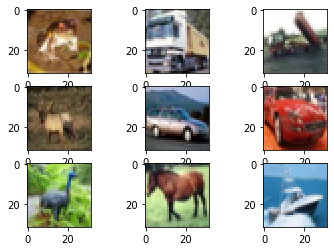

In [0]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(trainX[i])
pyplot.show()

### Define a method to load and prepare training images
* convert from unsigned ints to floats
* scale from [0,255] to [-1,1]

In [0]:
def load_real_samples():
    """load and prepare cifar10 training images"""
    
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X

### Define a method to select real images
* choose random instances
* retrieve selected images
* generate **real** class labels (1)

In [0]:
def generate_real_samples(dataset, n_samples):
    """select real samples"""
    
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

### Define a method to generate fake samples with class labels
* generate points in latent space
* predict outputs
* create **fake** class labels (0)

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """use the generator to generate n fake examples"""
    
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

### Define the discriminator model
The model must take an  image with a three color channel and 32×32 pixels in size from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.
The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification, and use LeakyReLU, Dropout, and the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

In [0]:
def define_discriminator(in_shape=(32,32,3)):
    """the standalone discriminator model"""
    
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

### Define a method to generate points in latent space as input for the generator
* generate points in the latent space
* the latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. 
* reshape into a batch of inputs for the network

In [0]:
def generate_latent_points(latent_dim, n_samples):
    """generate points in the latent space"""
    
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

### Define the standalone generator model
The generator model transforms a vector from the latent space with 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values.

In [0]:
def define_generator(latent_dim):
    """define the standalone generator model"""
    
    model = Sequential()
    n_nodes = 256 * 4 * 4
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    
    return model

### Define the DCGAN
*  make weights in the discriminator not trainable
*  connect the discriminator and the generator
*  compile the model

In [0]:
def define_gan(g_model, d_model):
    """define the combined generator and discriminator model, for updating the generator"""
    
    d_model.trainable = False
    model = Sequential()
    
    model.add(g_model)
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

### Define a method to plot the generated images

In [0]:
def save_plot(examples, epoch, n=7):
    """create and save a plot of generated images"""

    examples = (examples + 1) / 2.0
    
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
        
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

### Define a method to evaluate the discriminator
* plot generated images
* save generator model

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    """evaluate models and plot generated output"""

    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)

    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

### Define a method to plot generated images, save generator model
* enumerate batches over the training set
* get randomly selected real samples
* update discriminator model weights
* generate **fake** examples
* update discriminator model weights
* prepare points in latent space as input for the generator
* create inverted labels for the fake samples
* update the generator via the discriminator's error
* evaluate the model performance sometimes


In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    """plot generated images, save generator model"""
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):

            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            # 	(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
        if (i+1) % 50 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [0]:
# size of the latent space
latent_dim = 100

### Build the DCGAN
* create the discriminator
* create the generator
* create the gan
* load image data

In [0]:
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








>Accuracy real: 47%, fake: 86%
>Accuracy real: 63%, fake: 87%
>Accuracy real: 72%, fake: 91%
>Accuracy real: 73%, fake: 95%
